#### **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

#### **Importing Datasets**

In [2]:
customers_df = pd.read_csv('data/Customers.csv')
transactions_df = pd.read_csv('data/Transactions.csv')

#### **Feature Engineering**

Merge/Join customers and transactions datasets.

In [3]:
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

In [4]:
customer_features = (
    merged_df.groupby("CustomerID")
    .agg({
            "TotalValue": ["sum", "mean", "count"],
            "Quantity": "sum"})
    .reset_index()
)

customer_features.columns = [
    'CustomerID', 
    'total_spending', 
    'avg_order_value', 
    'transaction_count', 
    'total_quantity'
]

Merge with customer dataframe

In [5]:
final_df = pd.merge(customers_df, customer_features, on='CustomerID', how='inner')

One-Hot Encoding - Region Column

In [6]:
region_encoded = pd.get_dummies(final_df["Region"], prefix="region")
final_df = pd.concat([final_df, region_encoded], axis=1)

#### **Feature Preparation**

Drop unnecessary columns

In [7]:
final_df.drop(['CustomerName', 'SignupDate', 'Region'], axis=1, inplace=True)

Normalize numerical columns

In [8]:
columns_to_scale = [
    "total_spending",
    "avg_order_value",
    "transaction_count",
    "total_quantity",
]

scaler = StandardScaler()
final_df_scaled = final_df.copy()

final_df_scaled[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])

### **KMeans Clustering**

#### **Model Building**

KMeans function

In [17]:
def evaluate_kmeans():
    L = []
    silhouette_scores = []
    dbi_scores = []

    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        cluster_labels = kmeans.fit_predict(final_df_scaled.drop('CustomerID', axis=1))

        L.append(kmeans.inertia_)

        # Get cluster metrics
        dbi_scores.append(davies_bouldin_score(final_df_scaled.drop('CustomerID', axis=1), cluster_labels))

        silhouette_scores.append(silhouette_score(final_df_scaled.drop('CustomerID', axis=1), cluster_labels))
        
    return L, dbi_scores, silhouette_scores

L, dbi_scores, silhouette_scores = evaluate_kmeans()

**Plotting Curves**

Generating Elbow Curve and Silhoutte Plot ...


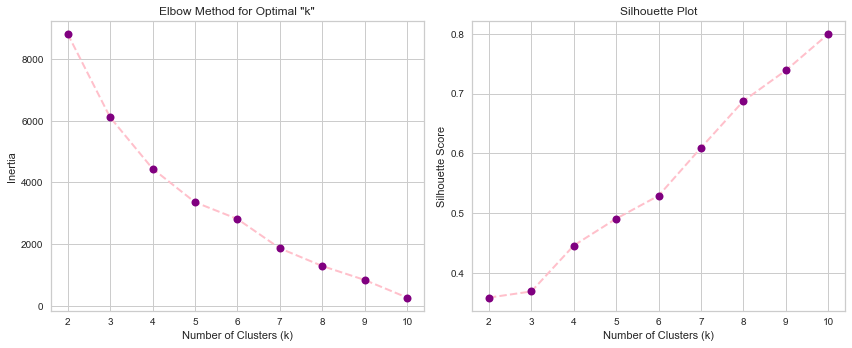

In [18]:
print("Generating Elbow Curve and Silhoutte Plot ...")

# 1. Plot Elbow Curve

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), L, color='pink', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='purple', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal "k"')
plt.grid(True)


# 2. Plot the Silhouette Scores

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, color='pink', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='purple', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Plot')
plt.grid(True)

plt.tight_layout()
plt.show()

Using KElbowVisualizer for Elbow Curve

Generating Elbow Curve with Yellowbrick...


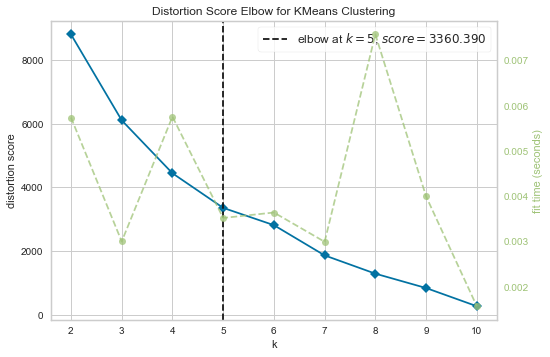

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
print("Generating Elbow Curve with Yellowbrick...")
kmeans = KMeans(init='k-means++', random_state=42)

visualizer = KElbowVisualizer(kmeans, k=(2, 11))

visualizer.fit(final_df_scaled.drop('CustomerID', axis=1))
visualizer.show()

Using SilhouetteVisualizer for Silhouette Plot

Generating Silhouette Plots with Yellowbrick...


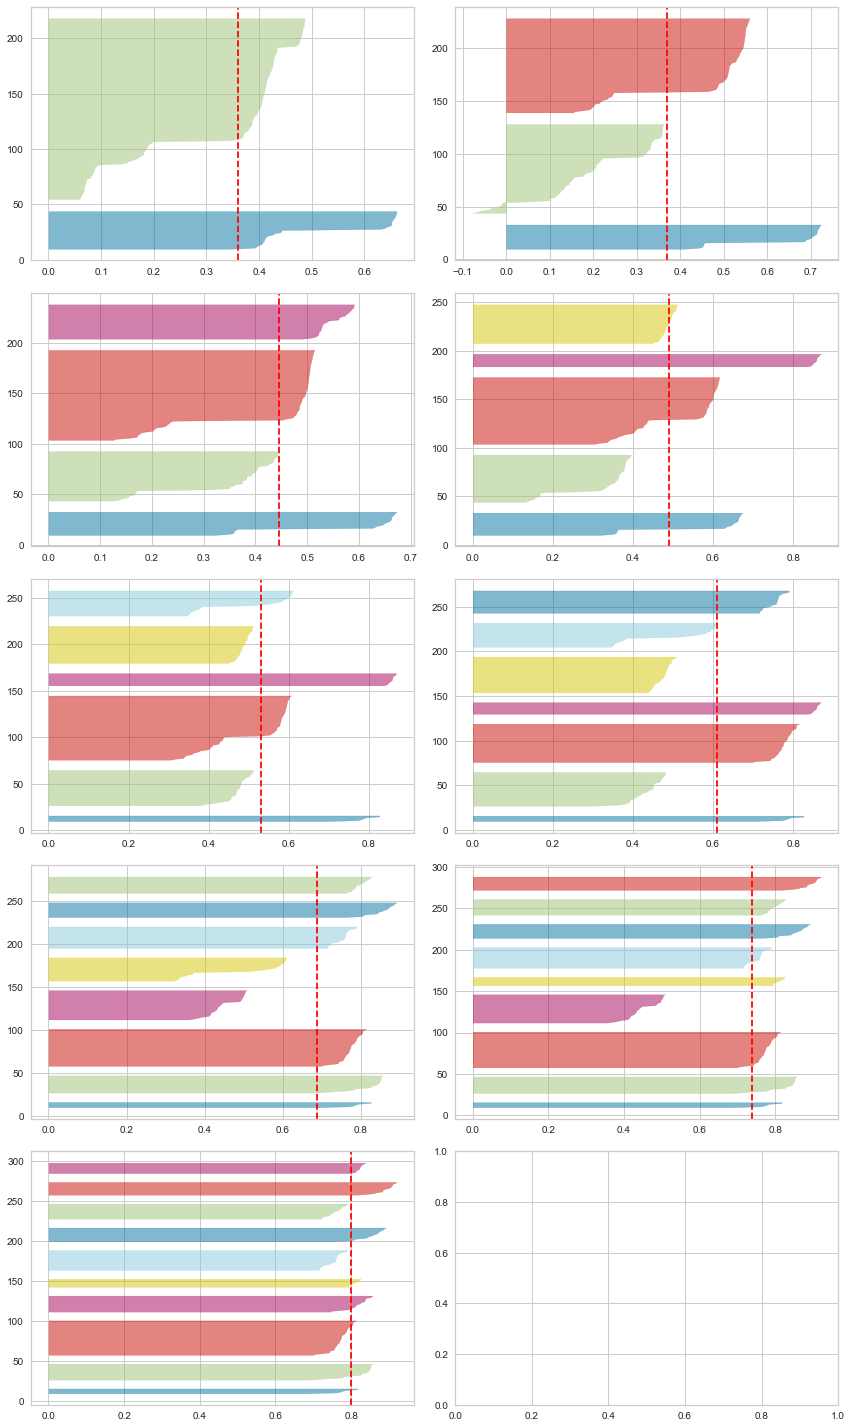

In [20]:
print("Generating Silhouette Plots with Yellowbrick...")
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=axes[i])
    visualizer.fit(final_df_scaled.drop('CustomerID', axis=1))

plt.tight_layout()
plt.show()

#### **Model Training**

In [21]:
optimal_k = 10

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
final_df_scaled['Cluster_KMeans'] = kmeans.fit_predict(final_df_scaled.drop('CustomerID', axis=1))

#### **Model Evaluation**

Using Davies-Boudin Index (DBI) & Silhoutte Score as metrics.

In [22]:
kmeans_dbi = davies_bouldin_score(final_df_scaled.drop(['CustomerID', 'Cluster_KMeans'], axis=1), final_df_scaled['Cluster_KMeans'])

kmeans_silhouette = silhouette_score(final_df_scaled.drop(['CustomerID', 'Cluster_KMeans'], axis=1), final_df_scaled['Cluster_KMeans'])

print(f'KMeans DBI: {kmeans_dbi}')
print(f'KMeans Silhouette Score: {kmeans_silhouette}')

KMeans DBI: 0.2791959704473309
KMeans Silhouette Score: 0.799486695710298


#### **Clusters Visualization**

Use PCA to reduce dimensions to 2D for visualization

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_df_scaled.drop(['CustomerID', 'Cluster_KMeans'], axis=1))

final_df_scaled['PCA1'] = pca_result[:, 0]
final_df_scaled['PCA2'] = pca_result[:, 1]

Scatterplot for visualizing clusters

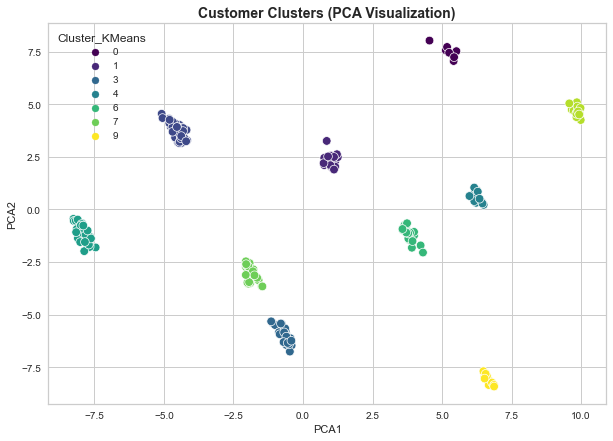

In [24]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', data=final_df_scaled, palette='viridis', s=75)

plt.title('Customer Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
plt.show()

### **Hierarchical Clustering**

#### **Model Building**

Dendrogram for Hierarchical Clustering

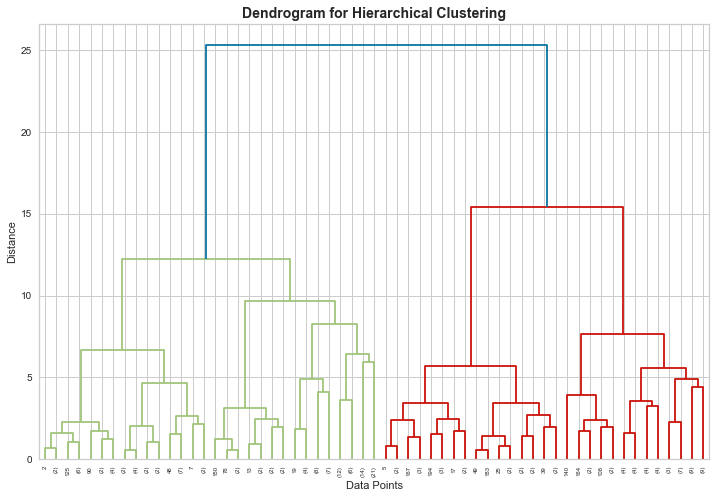

In [9]:
linkage_matrix = linkage(final_df_scaled.drop('CustomerID', axis=1), method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)

plt.title('Dendrogram for Hierarchical Clustering', fontsize=14, fontweight='bold')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

Cophenetic Correlation

In [10]:
coph_corr, _ = cophenet(linkage_matrix, pdist(final_df_scaled.drop('CustomerID', axis=1)))
print(f"Cophenetic Correlation Coefficient: {coph_corr:.4f}")


Cophenetic Correlation Coefficient: 0.5302


Evaluate Hierarchical Clustering for Different "k"

In [11]:
results = []

for k in range(2, 11):
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    final_df_scaled[f'Cluster_{k}'] = hierarchical.fit_predict(final_df_scaled.drop('CustomerID', axis=1))
    
    # Evaluate Silhouette Score
    silhouette_avg = silhouette_score(final_df_scaled.drop(['CustomerID', f'Cluster_{k}'], axis=1),final_df_scaled[f'Cluster_{k}'])
    
    # Evaluate Davies-Bouldin Index
    dbi = davies_bouldin_score(final_df_scaled.drop(['CustomerID', f'Cluster_{k}'], axis=1),
        final_df_scaled[f'Cluster_{k}'])
    
    results.append({'k': k, 'Silhouette_Score': silhouette_avg, 'DBI': dbi})


results_df = pd.DataFrame(results)
print("\nResults:")
print(results_df)



Results:
    k  Silhouette_Score       DBI
0   2          0.298048  1.282766
1   3          0.299715  1.098022
2   4          0.245209  1.274814
3   5          0.384799  0.970388
4   6          0.414209  1.002637
5   7          0.520555  0.790636
6   8          0.571516  0.673397
7   9          0.563647  0.699622
8  10          0.650050  0.574928


Plot Silhouette Scores and DBI

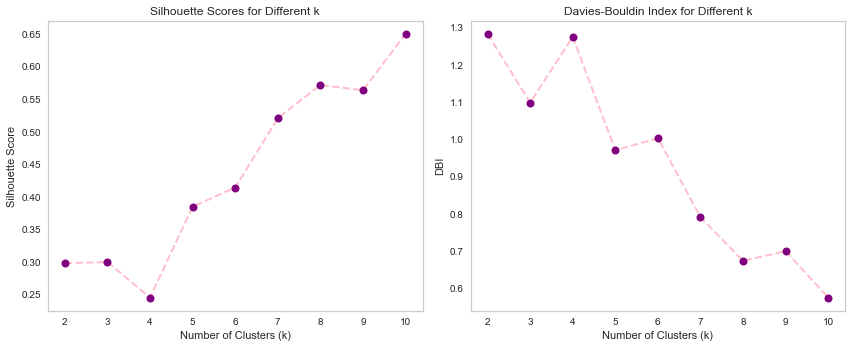

In [12]:
plt.figure(figsize=(12, 5))

# 1. Silhouette Score Plot

plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['Silhouette_Score'], color='pink', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='purple', markersize=8)

plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()


# 2. DBI Plot

plt.subplot(1, 2, 2)
plt.plot(results_df['k'], results_df['DBI'], color='pink', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='purple', markersize=8)

plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI')
plt.grid()

plt.tight_layout()
plt.show()

Select Optimal "k" Based on Metrics

In [13]:
optimal_k_silhouette = results_df.loc[results_df['Silhouette_Score'].idxmax(), 'k']
optimal_k_dbi = results_df.loc[results_df['DBI'].idxmin(), 'k']

print(f"\nOptimal k based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal k based on DBI: {optimal_k_dbi}")


Optimal k based on Silhouette Score: 10
Optimal k based on DBI: 10


#### **Model Training**

In [14]:
optimal_k = 10

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
final_df_scaled['Cluster_Hierarchical'] = hierarchical.fit_predict(final_df_scaled.drop('CustomerID', axis=1))


#### **Model Evaluation**

Using Davies-Boudin Index (DBI) & Silhoutte Score as metrics.

In [15]:
hierarchical_dbi = davies_bouldin_score(final_df_scaled.drop(['CustomerID', 'Cluster_Hierarchical'], axis=1), final_df_scaled['Cluster_Hierarchical'])

hierarchical_silhouette = silhouette_score(final_df_scaled.drop(['CustomerID', 'Cluster_Hierarchical'], axis=1), final_df_scaled['Cluster_Hierarchical'])

print(f'Hierarchical DBI: {hierarchical_dbi}')
print(f'Hierarchical Silhouette Score: {hierarchical_silhouette}')

Hierarchical DBI: 0.36755299083461246
Hierarchical Silhouette Score: 0.741937664877681


#### **Clusters Visualization**

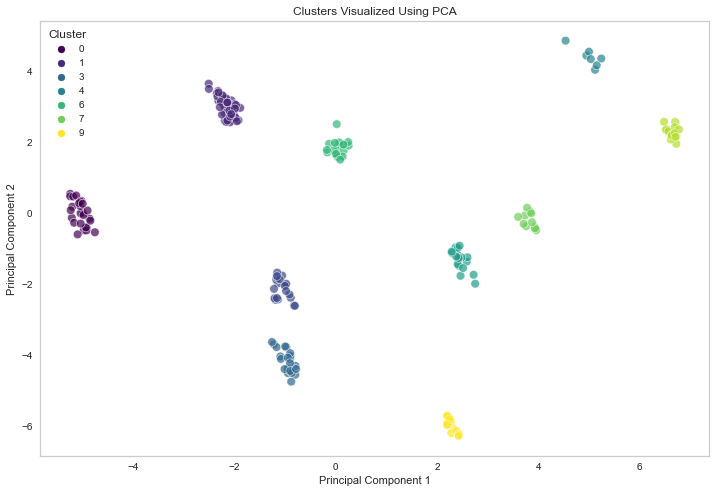

In [16]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
final_df_scaled['PCA1'] = pca.fit_transform(final_df_scaled.drop(['CustomerID', 'Cluster_Hierarchical'], axis=1))[:, 0]
final_df_scaled['PCA2'] = pca.fit_transform(final_df_scaled.drop(['CustomerID', 'Cluster_Hierarchical'], axis=1))[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Hierarchical', data=final_df_scaled, palette='viridis',s=75, alpha=0.7)

plt.title('Clusters Visualized Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

plt.grid()
plt.show()

### **Model Comparision**

In [25]:
comparison_data = {
    "Algorithm": ["KMeans", "Hierarchical"],
    "Silhouette Score": [kmeans_silhouette, hierarchical_silhouette],
    "DBI (Davies-Bouldin Index)": [kmeans_dbi, hierarchical_dbi],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

      Algorithm  Silhouette Score  DBI (Davies-Bouldin Index)
0        KMeans          0.799487                    0.279196
1  Hierarchical          0.741938                    0.367553
